# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

### *** YOUR RUNI EMAILS HERE ***
shahar.shvili@post.runi.ac.il,itay.baror@post.runi.ac.il
---
---


In [175]:
# Import necessary libraries
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

**Overview**

when using Adaboost we are given feature vectors 
$x_i \in \mathbb{R}^d$ 
with binary lables 
$y_i \in \{-1, +1\}$ 
our goal is to combine many weak learners classifiers into a strong classifier with low traning error. the algorithm achieves this by iterating over the stumps and adding the ones that make the model better and adjusting the weights of the samples according to if they are missclassified or not 

**Algorithem**

let n be the number of samples, and T the number of boosting rounds

**Step 1: Initialization**

initialize sample weights for every 
$i=1,...,n$ $w_i=1/n$ 
at the beginning all samples  are equally as important as we continue the weights will change acording to if we misclassifed the samples
initialize the ensemble prediction function 
$H_0=0$ 
we start with no classifier while we build the model we will add stumps to here 

**Step 2:**

For t=0,....,T-1
each iteration adds one weak learner and updates the weights 

**Step 2.1: Train the weak learner**

Train the weak leaner using the current weights. this means that samples with larger weights have more influence on the traning. 

**Step 2.2: Compute weighted classification error**

$\epsilon = \sum_{i : h(x_i) \neq y_i} w_i$

calculate how good the classification did in the weighted dataset  
- if $\epsilon<=0.5$ then we got to the end since our current weak learner does not add to our classification 
- if not continue to the next step 

**Step 2.3: Compute the weight of the weak learner**

$\alpha = \frac{1}{2} \ln\!\left(\frac{1-\epsilon}{\epsilon}\right)$

when weak learners have low error then we want them to matter more so there weight will be large 

**Step 2.4: Update the model with the current weak learner**

add the current weak learner to the model of all the weak learners we add up until now 
$H_{t+1} = H_t + \alpha h$

**Step 2.5: Update the weights**
update the weights of samples that are currently in the model 

$w_i \leftarrow \frac{w_i e^{-\alpha h(x_i) y_i}}{2\sqrt{\epsilon (1-\epsilon)}}$

misclassified samples get higher weights correctly classified ones get lower weights 

**Step 3: return the final model**

return $H(x) = \operatorname{sign}\!\left( \sum_{t=1}^T \alpha_t h_t(x) \right)$


# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

In [176]:
# import numpy as np
# from sklearn.tree import DecisionTreeClassifier


# # Part 1: Implementing AdaBoost
# class AdaBoostCustom:
#     def __init__(self, T):
#         self.T = T
#         self.alphas = []
#         self.models = []
#         self.classes = None
#         # Note: You may add more attributes

#     def fit(self, X, y):
#         # Your code here
#         pass
    
#     def predict(self, X):  
#         # Your code here
#         pass



import numpy as np
from sklearn.tree import DecisionTreeClassifier


class AdaBoostCustom:
    def __init__(self, T=100, base_estimator=None, learning_rate=1.0, random_state=None):
        self.T = int(T)
        self.learning_rate = float(learning_rate)
        self.random_state = random_state
        self.base_estimator = base_estimator or DecisionTreeClassifier(
            max_depth=1, random_state=random_state
        )
        self.alphas = []
        self.models = []
        self.neg_class = None
        self.pos_class = None

    # Encode to {-1,+1} by picking a deterministic positive/negative class.
    def encode_pm1(self, y):
        y = np.asarray(y)
        classes = np.unique(y)
        if classes.size != 2:
            raise ValueError("AdaBoostCustom supports binary classification only.")
        self.neg_class, self.pos_class = classes[0], classes[1]
        return np.where(y == self.pos_class, 1, -1)

    # Decode {-1,+1} back to original labels.
    def decode_labels(self, y_pm1):
        return np.where(y_pm1 >= 0, self.pos_class, self.neg_class)

    # Core boosting loop with weighted trees, SAMME alpha, and weight renormalization.
    def fit(self, X, y):
        X = np.asarray(X)
        y_pm1 = self.encode_pm1(y).astype(float)

        n = X.shape[0]
        D = np.full(n, 1.0 / n)
        eps = 1e-12

        self.alphas = []
        self.models = []

        for t in range(self.T):
            stump = DecisionTreeClassifier(**self.base_estimator.get_params())
            stump.fit(X, y_pm1, sample_weight=D)

            h_pm1 = stump.predict(X).astype(float)
            err = float(np.sum(D * (h_pm1 != y_pm1)))
            err = float(np.clip(err, 0.0, 1.0))

            if err >= 0.5 - 1e-15:
                if t == 0:
                    self.alphas.append(1e-6)
                    self.models.append(stump)
                break

            alpha = 0.5 * np.log((1.0 - err) / (err + eps))
            alpha *= self.learning_rate

            D *= np.exp(-alpha * y_pm1 * h_pm1)
            s = D.sum()
            if s == 0.0:
                self.alphas.append(alpha)
                self.models.append(stump)
                break
            D /= s

            self.alphas.append(alpha)
            self.models.append(stump)

        return self

    # Margin F(x) = sum_t alpha_t h_t(x).
    def decision_function(self, X):
        if not self.models:
            raise ValueError("Model is not fitted.")
        X = np.asarray(X)
        F = np.zeros(X.shape[0], dtype=float)
        for alpha, stump in zip(self.alphas, self.models):
            F += alpha * stump.predict(X).astype(float)
        return F

    # Final classifier H(x) = sign(F(x)); ties go to +1.
    def predict(self, X):
        F = self.decision_function(X)
        y_pm1 = np.sign(F)
        y_pm1[y_pm1 == 0] = 1
        return self.decode_labels(y_pm1.astype(int))

# Generate data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

This synthetic binary dataset is ideal for a unit test of AdaBoost because it’s clean, separable, and reproducible. I set n_features=10 with n_informative=10 and n_redundant=0 so every feature carries signal and simple axis-aligned stumps beat 0.5 error (weak-learning holds). A large margin (class_sep=2.0) and no label noise (flip_y=0.0) mean our implementation and AdaBoostClassifier should quickly agree and reach high accuracy—so any discrepancy points to a bug, not the data. Using n_samples=10000, a stratified test_size=0.3, n_clusters_per_class=1, and random_state=0 keeps results stable and deterministic while still fast to run.

In [177]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def simple_dataset(n=800, class_sep=2.0, test_size=0.3, random_state=0):
    X, y = make_classification(
        n_samples=n, n_features=10, n_informative=10, n_redundant=0,
        n_clusters_per_class=1, class_sep=class_sep, flip_y=0.0,
        random_state=random_state
    )
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)


# --- generate separable dataset ---
X_train, X_test, y_train, y_test = simple_dataset(n=10000, class_sep=2.0, test_size=0.3, random_state=0)



# AdaBoost demonstration 
Demonstrate your AdaBoost implementation.

Add plots and figures. 

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

In [178]:
custom_model = AdaBoostCustom(T=10)
sklearn_model = AdaBoostClassifier(n_estimators=10, random_state=42)

# Your code here
custom_model.fit(X_train, y_train)
sklearn_model.fit(X_train, y_train) 
# Predictions
y_pred_custom = custom_model.predict(X_test)
y_pred_sklearn = sklearn_model.predict(X_test)
# Accuracy
acc_custom = accuracy_score(y_test, y_pred_custom)
acc_sklearn = accuracy_score(y_test, y_pred_sklearn)
print(f"Custom AdaBoost Accuracy: {acc_custom:.4f}")
print(f"Sklearn AdaBoost Accuracy: {acc_sklearn:.4f}")



Custom AdaBoost Accuracy: 0.9667
Sklearn AdaBoost Accuracy: 0.9667


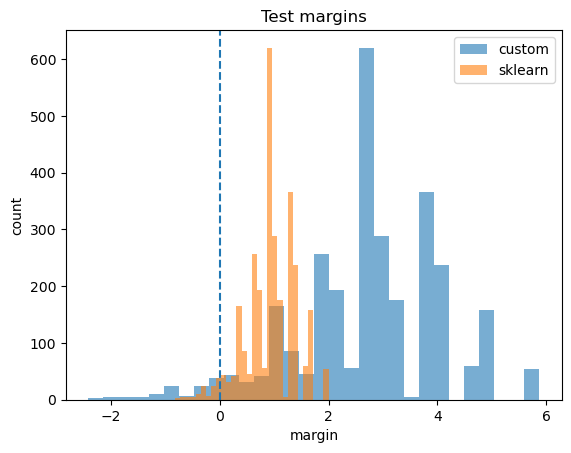

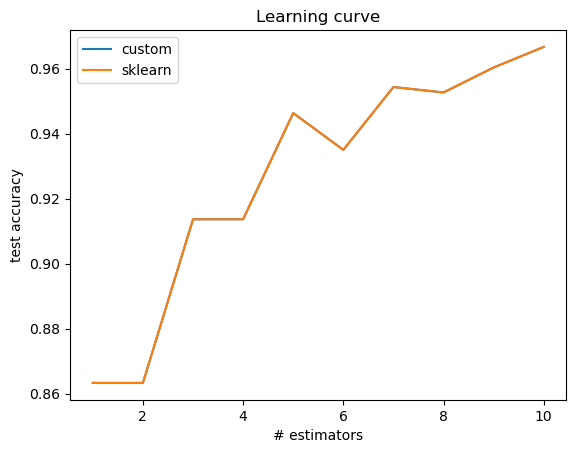

In [179]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# assumes: custom_model, sklearn_model already fit; X_test, y_test exist

def _pm1(y):
    c = np.unique(y); return np.where(y == c[1], 1.0, -1.0)

# Margins (y·F(x)) on test set
m_c = _pm1(y_test) * custom_model.decision_function(X_test)
m_s = _pm1(y_test) * sklearn_model.decision_function(X_test)
plt.figure(); plt.hist(m_c, bins=30, alpha=.6, label="custom")
plt.hist(m_s, bins=30, alpha=.6, label="sklearn"); plt.axvline(0, ls="--")
plt.xlabel("margin"); plt.ylabel("count"); plt.title("Test margins"); plt.legend(); plt.show()

# Test accuracy vs. #estimators
def _staged_acc_custom(m, X, y):
    ypm1 = _pm1(y); F = np.zeros(X.shape[0]); acc = []
    for a, h in zip(m.alphas, m.models):
        F += a * h.predict(X).astype(float)
        yhat = np.sign(F); yhat[yhat == 0] = 1
        acc.append((yhat == ypm1).mean())
    return np.array(acc)

acc_custom = _staged_acc_custom(custom_model, X_test, y_test)
acc_skl = np.array([accuracy_score(y_test, yp) for yp in sklearn_model.staged_predict(X_test)])

t1 = np.arange(1, len(acc_custom)+1); t2 = np.arange(1, len(acc_skl)+1)
plt.figure(); plt.plot(t1, acc_custom, label="custom")
plt.plot(t2, acc_skl, label="sklearn")
plt.xlabel("# estimators"); plt.ylabel("test accuracy")
plt.title("Learning curve"); plt.legend(); plt.show()

The top plot shows the distribution of test margins y\cdot F(x). Bars to the right of the dashed 0 line are correct predictions; both models’ mass is mostly positive, so both perform well. The custom model’s histogram is shifted further right, indicating larger margins (stronger confidence). That scale difference is expected—margins can be scaled differently across implementations even when accuracy is similar. The bottom learning curve shows test accuracy rising as we add estimators and then flattening around ~96–97%, which is typical AdaBoost behavior on a clean dataset: big early gains, then diminishing returns (and potential overfitting if you keep increasing T).

In the margin histogram, bigger bars to the right mean more confident correct predictions, but the scale of the margins isn’t comparable across the two models. My custom AdaBoost uses the discrete SAMME variant, where each stump adds a fixed ±α, so scores grow larger. The sklearn model here uses the default SAMME.R, which adds log-odds from the weak learner, compressing scores toward zero—hence its histogram sits closer to 0 even with similar accuracy. Larger margins in this plot therefore do not imply better performance; they reflect different margin definitions.

# Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [180]:
# --- Datasets ---
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def make_label_noise(n_samples=4000, n_features=20, n_informative=8,
                     class_sep=0.8, flip_y=0.20, test_size=0.3, random_state=1):
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, n_redundant=n_features-n_informative,
        n_clusters_per_class=2, class_sep=class_sep, flip_y=flip_y,
        random_state=random_state)
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

def make_outliers_imbalance(n_samples=4000, n_features=20, n_informative=8,
                            class_sep=0.9, flip_y=0.10, weights=(0.7,0.3),
                            outlier_frac=0.02, test_size=0.3, random_state=7):
    X, y = make_classification(n_samples=n_samples, n_features=n_features,
        n_informative=n_informative, n_redundant=n_features-n_informative,
        n_clusters_per_class=2, class_sep=class_sep, flip_y=flip_y,
        weights=list(weights), random_state=random_state)
    # inject outliers
    rng = np.random.default_rng(random_state)
    k = max(1, int(outlier_frac * n_samples))
    idx = rng.choice(n_samples, k, replace=False)
    X[idx] += rng.normal(0, 6.0, size=(k, n_features))
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

# --- PCA snapshot helper ---


# Example quick looks (optional):
# Xtr, Xte, ytr, yte = make_label_noise(); pca_scatter(Xtr, ytr, "LabelNoise (train, PCA)")
# Xtr, Xte, ytr, yte = make_outliers_imbalance(); pca_scatter(Xtr, ytr, "Outliers+Imbalance (train, PCA)")

In [181]:
# Visualize data
def pca_scatter(X, y, title=""):
    Z = PCA(n_components=2, random_state=0).fit_transform(X)
    plt.figure(); plt.scatter(Z[:,0], Z[:,1], c=y, s=10, edgecolor="k")
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.show()

# Test algorithms
Test your AdaBoost, a library implementation of AdaBoost and at least two additional models, one of which must be another boosting algorithm on your two datasets.

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In [182]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

# Set up models 
models = {
    "AdaBoostCustom": AdaBoostCustom(T=50, random_state=42),
    "AdaBoostSklearn": AdaBoostClassifier(n_estimators=50, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, max_depth=2, random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
}

datasets = {
    "Clean separable": make_label_noise,
    "Noisy overlap": make_outliers_imbalance
}

# ===============================
# Test and visualize
# ===============================
for dname, data_func in datasets.items():
    Xtr, Xte, ytr, yte = data_func()
    print(f"\nDataset: {dname} | Train size: {Xtr.shape[0]} | Test size: {Xte.shape[0]}")
    
    for mname, model in models.items():
        model.fit(Xtr, ytr)
        ypred = model.predict(Xte)
        acc = accuracy_score(yte, ypred)
        print(f"  Model: {mname:15s} | Test Accuracy: {acc:.4f}")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve, average_precision_score

def _score(m, X):
    if hasattr(m, "decision_function"):
        s = m.decision_function(X)
        return s.ravel() if s.ndim > 1 else s
    if hasattr(m, "predict_proba"):
        return m.predict_proba(X)[:, 1]
    return None  # skip models without a ranking score

for ds_name, ds_fn in datasets.items():
    Xtr, Xte, ytr, yte = ds_fn()

    fitted = {n: clone(clf).fit(Xtr, ytr) for n, clf in models.items()}

    p = PCA(n_components=2, random_state=0).fit(Xtr)
    Xt, Xv = p.transform(Xtr), p.transform(Xte)

    plt.figure(figsize=(5,4))
    plt.scatter(Xt[:,0], Xt[:,1], c=ytr, s=6, alpha=.6)
    plt.scatter(Xv[:,0], Xv[:,1], c=yte, s=14, alpha=.9, marker='x')
    plt.title(f"{ds_name} • PCA(2)"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.tight_layout()

    plt.figure(figsize=(5.8,4))
    for name, m in fitted.items():
        s = _score(m, Xte)
        if s is None: continue
        pr, rc, _ = precision_recall_curve(yte, s)
        ap = average_precision_score(yte, s)
        plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
    plt.title(f"{ds_name} • Precision–Recall (test)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(fontsize=8); plt.tight_layout()





Dataset: Clean separable | Train size: 2800 | Test size: 1200
  Model: AdaBoostCustom  | Test Accuracy: 0.7150
  Model: AdaBoostSklearn | Test Accuracy: 0.7150
  Model: GradientBoosting | Test Accuracy: 0.7958
  Model: RandomForest    | Test Accuracy: 0.8425

Dataset: Noisy overlap | Train size: 2800 | Test size: 1200
  Model: AdaBoostCustom  | Test Accuracy: 0.8267
  Model: AdaBoostSklearn | Test Accuracy: 0.8267
  Model: GradientBoosting | Test Accuracy: 0.8608
  Model: RandomForest    | Test Accuracy: 0.8983


TypeError: Cannot clone object '<__main__.AdaBoostCustom object at 0x15979b890>' (type <class '__main__.AdaBoostCustom'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [ ]:
# Test and visualize

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 